In [115]:
import pandas as pd
import os
from ast import literal_eval
import seaborn as sns
sns.set_context(font_scale=1.1)
sns.set_color_codes("dark")

from matplotlib import pyplot as plt
from datetime import timedelta

# Processing text files into one Json File for Wise and PayPal.

In [116]:
all_details = []
for wise_file in os.listdir("./data/Wise"):
    # Looping through text files containing the reviews data
    data = [literal_eval(i.strip()) for i in open(f'./data/Wise/{wise_file}').readlines()]
    all_details.extend(data)
# Convert the list data into pandas DataFrame.
df = pd.DataFrame(all_details)
df.head(3)

,platform,id,stars,title,message,review_date,review_time,CompanyReply,CompanyReplyDate,CompanyReplyTime
0,Wise,60b8b3f2f9f4870b70161798,5,Fast and transparent money transfer!,"Here is the fast, affordable, and transparent ...",2021-06-03,10:50:26,None,None,None
1,Wise,60b8b1fbf9f4870b70161539,5,Everything you can ask from a money transfer s...,Everything you can ask from a money transfer s...,2021-06-03,10:42:03,None,None,None
2,Wise,60b8b172f9f4870a94b4ca3a,5,Very quick and reliable transactions,I use wise frequently and very happy with the ...,2021-06-03,10:39:46,None,None,None


In [117]:
# Joining date and times for review date and company reply date to made datetime then turn the 
# result into a valida pandas dataframe.
df["review_datetime"]  = pd.to_datetime(df["review_date"] +"T"+ df["review_time"])
df["company_reply_datetime"] = pd.to_datetime(df["CompanyReplyDate"] + "T" + df["CompanyReplyTime"])

# Compute time taken (in days) for the company to reply for reviews.
df["time_taken_to_reply"] = ((df["company_reply_datetime"] - df["review_datetime"]).dt.total_seconds() / (60 * 60 * 24)).round()
# If company has not reply to a revieww, time_taken_to_reply will be NaN. 
# We will replace NaN values in this column with a placeholder (-999)
df["time_taken_to_reply"] = df["time_taken_to_reply"].fillna(-999).astype(int)

# Extract year from review datetime.
df['Year'] = df['review_datetime'].dt.year

# Most of the data we use will be aggregated at a month level therefore creating a Month-Year field.
df['Month-Year'] = df['review_datetime'].dt.to_period('m')
df['Month-Year'] = df['Month-Year'].dt.to_timestamp()

df.head(2)

,platform,id,stars,title,message,review_date,review_time,CompanyReply,CompanyReplyDate,CompanyReplyTime,review_datetime,company_reply_datetime,time_taken_to_reply,Year,Month-Year
0,Wise,60b8b3f2f9f4870b70161798,5,Fast and transparent money transfer!,"Here is the fast, affordable, and transparent ...",2021-06-03,10:50:26,None,None,None,2021-06-03 10:50:26,NaT,-999,2021,2021-06-01
1,Wise,60b8b1fbf9f4870b70161539,5,Everything you can ask from a money transfer s...,Everything you can ask from a money transfer s...,2021-06-03,10:42:03,None,None,None,2021-06-03 10:42:03,NaT,-999,2021,2021-06-01


In [118]:
# Find the earliest review date
min_date = df['review_datetime'].min()
print(min_date)
# Find the latest review date in the daraset
max_date = df['review_datetime'].max()
print(max_date)
# Calculate the date 1 year ago from the latest date - we will use this later.
one_year_ago = max_date - timedelta(days=365)

2020-10-05 18:58:20
2023-11-06 08:19:27


The reviews data we are using here were collected between 2020-10-05 and 2023-11-06 (a duration of 3 years and 1 month)

## Average Ratings

In [119]:
df.groupby('Year').agg({'stars': 'mean'}).reset_index().round(1)

,Year,stars
0,2020,4.7
1,2021,4.6
2,2022,4.5
3,2023,3.8


## Reviews over Time

For the rest of the analysis, we will analyze reviews after 2022-04-01 so that we can reduce clutter on our plots.

In [120]:
# Filtering revieww made after April 2022.
df = df[df["review_datetime"]>="2022-04-01"]

<Axes: xlabel='Month-Year', ylabel='Count'>

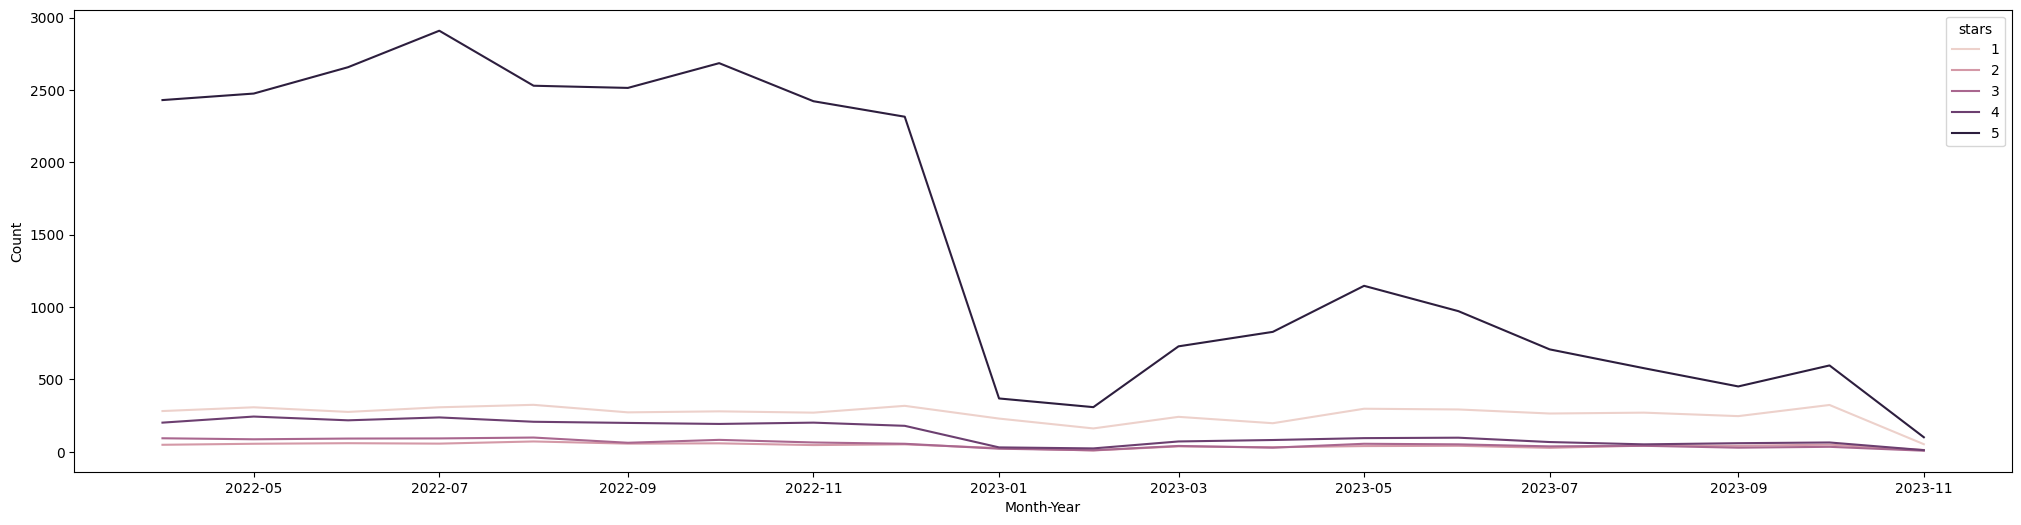

In [121]:
# df['Month-Year'] = df['review_datetime'].dt.strftime('%y-%m')
reviews_over_time = df.groupby(['Month-Year', 'stars']).size().reset_index(name='Count')
plt.figure(figsize=(25, 6))
sns.lineplot(data= reviews_over_time, x="Month-Year", y="Count", hue="stars")

## Ratings Across Time

In [122]:
ratings_over_time = df.groupby('Month-Year').agg({'stars': 'mean'}).reset_index()
ratings_over_time['stars'] = ratings_over_time['stars'].round(1)

In [123]:
# Overal rating for review collected between 2022 April and 2023 November
ratings_over_time["stars"].mean().round()

4.0

In [124]:
# Rating in 2023
ratings_over_time[ratings_over_time["Month-Year"]>"2023-01-01"]["stars"].mean().round(1)

3.8

In [125]:
# Raing in 2022
ratings_over_time[(ratings_over_time["Month-Year"]>"2022-01-01") &
                  (ratings_over_time["Month-Year"]<"2023-01-01")]["stars"].mean().round(1)

4.5

In [126]:

def plot_barplots(df1, x, y, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(25, 10))
    # sns.barplot(data= ratings_over_time, x="Month-Year", y="stars")

    ax = sns.barplot(data=df1, x=x, y=y)

    # Add labels within the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    # Add labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()


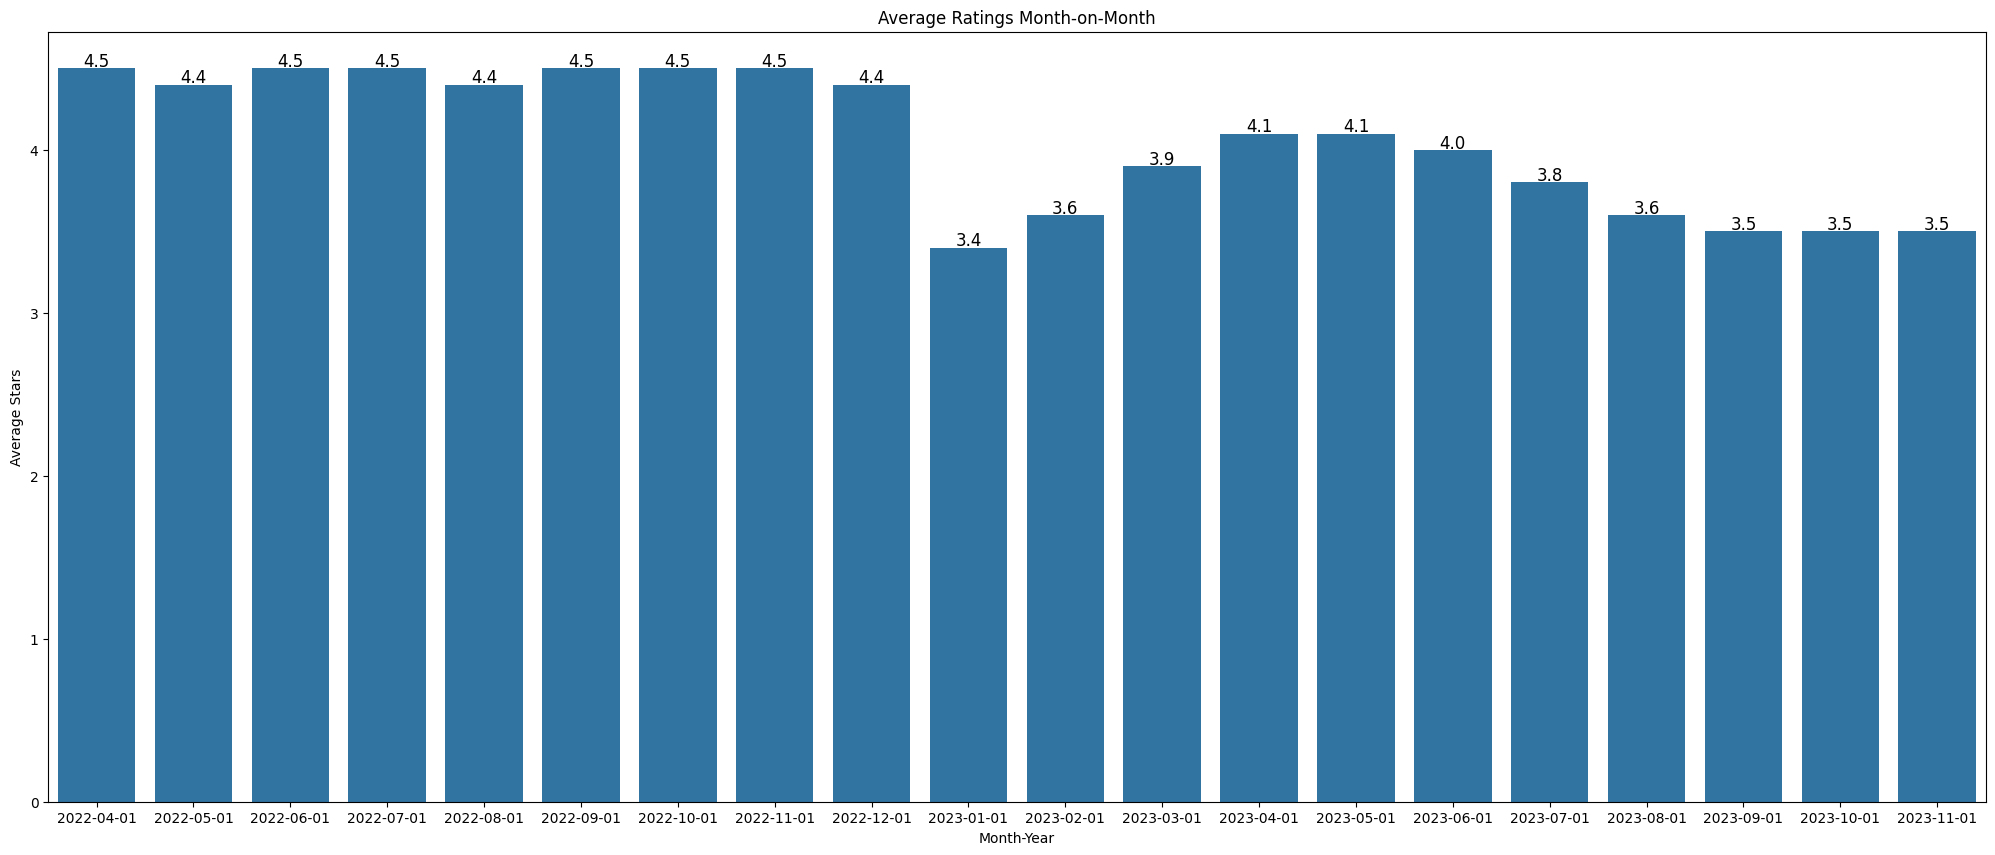

In [127]:
plot_barplots(df1=ratings_over_time, x="Month-Year", y="stars", 
              title="Average Ratings Month-on-Month", xlabel="Month-Year", 
              ylabel="Average Stars")

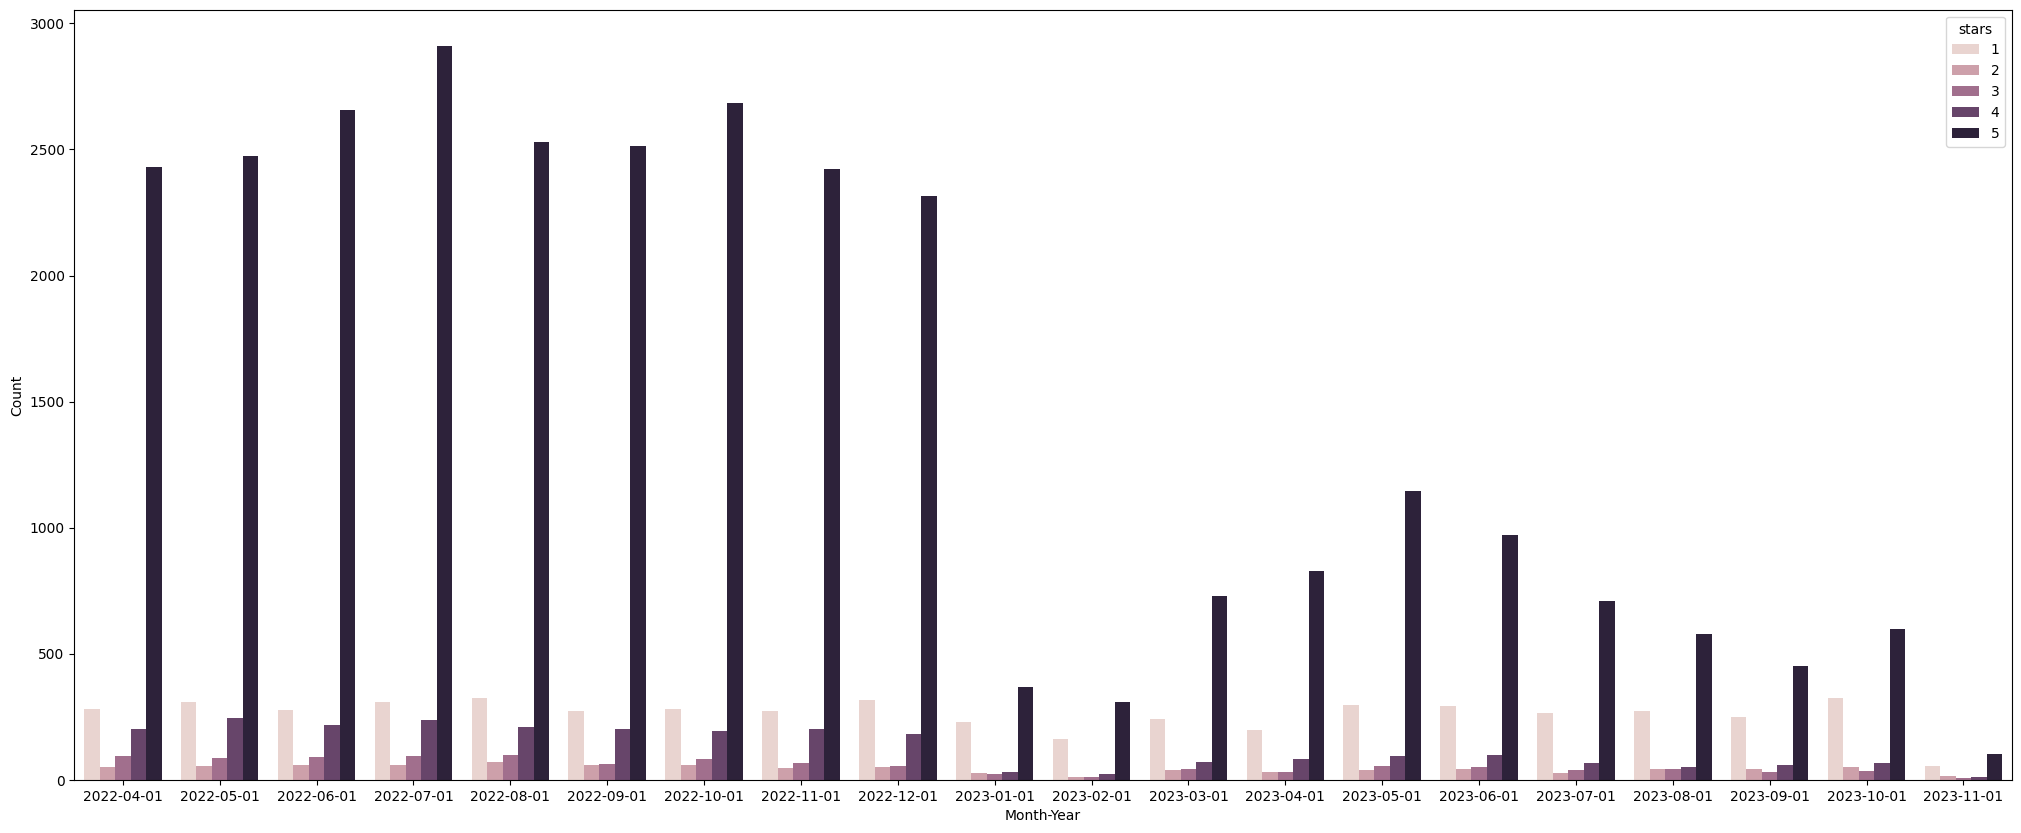

In [128]:
ratings_overtime_2 = df.groupby(['Month-Year', 'stars']).size().reset_index(name='Count')
plt.figure(figsize=(25, 10))
sns.barplot(data=ratings_overtime_2, x="Month-Year", y="Count", hue="stars");

In [129]:
ratings_overtime_2 = df.groupby(['Month-Year', 'stars']).size().reset_index(name='Count')

# Pivot the table to make it easier to calculate percentages
pivoted = ratings_overtime_2.pivot(index='Month-Year', columns='stars', values='Count')

# Calculate the percentages
pivoted['1-Star %'] = ((pivoted[1] / pivoted.sum(axis=1)) * 100).round(1)
pivoted['5-Star %'] = ((pivoted[5] / pivoted.sum(axis=1)) * 100).round(1)
pivoted["Cumulative 1 and 5"] = pivoted['1-Star %'] + pivoted['5-Star %']

# Reset the index
pivoted.reset_index(inplace=True)

In [130]:
pivoted

stars,Month-Year,1,2,3,4,5,1-Star %,5-Star %,Cumulative 1 and 5
0,2022-04-01,282,49,94,202,2430,9.2,79.3,88.5
1,2022-05-01,308,56,87,244,2475,9.7,77.8,87.5
2,2022-06-01,276,60,92,218,2657,8.4,80.2,88.6
3,2022-07-01,308,57,93,238,2909,8.5,80.5,89.0
4,2022-08-01,325,72,99,208,2529,10.1,78.0,88.1
5,2022-09-01,273,57,63,200,2514,8.8,80.7,89.5
6,2022-10-01,280,59,83,193,2685,8.5,81.2,89.7
7,2022-11-01,271,47,65,202,2422,9.0,80.3,89.3
8,2022-12-01,318,52,56,180,2315,10.9,79.0,89.9
9,2023-01-01,230,26,22,31,369,33.9,51.8,85.7


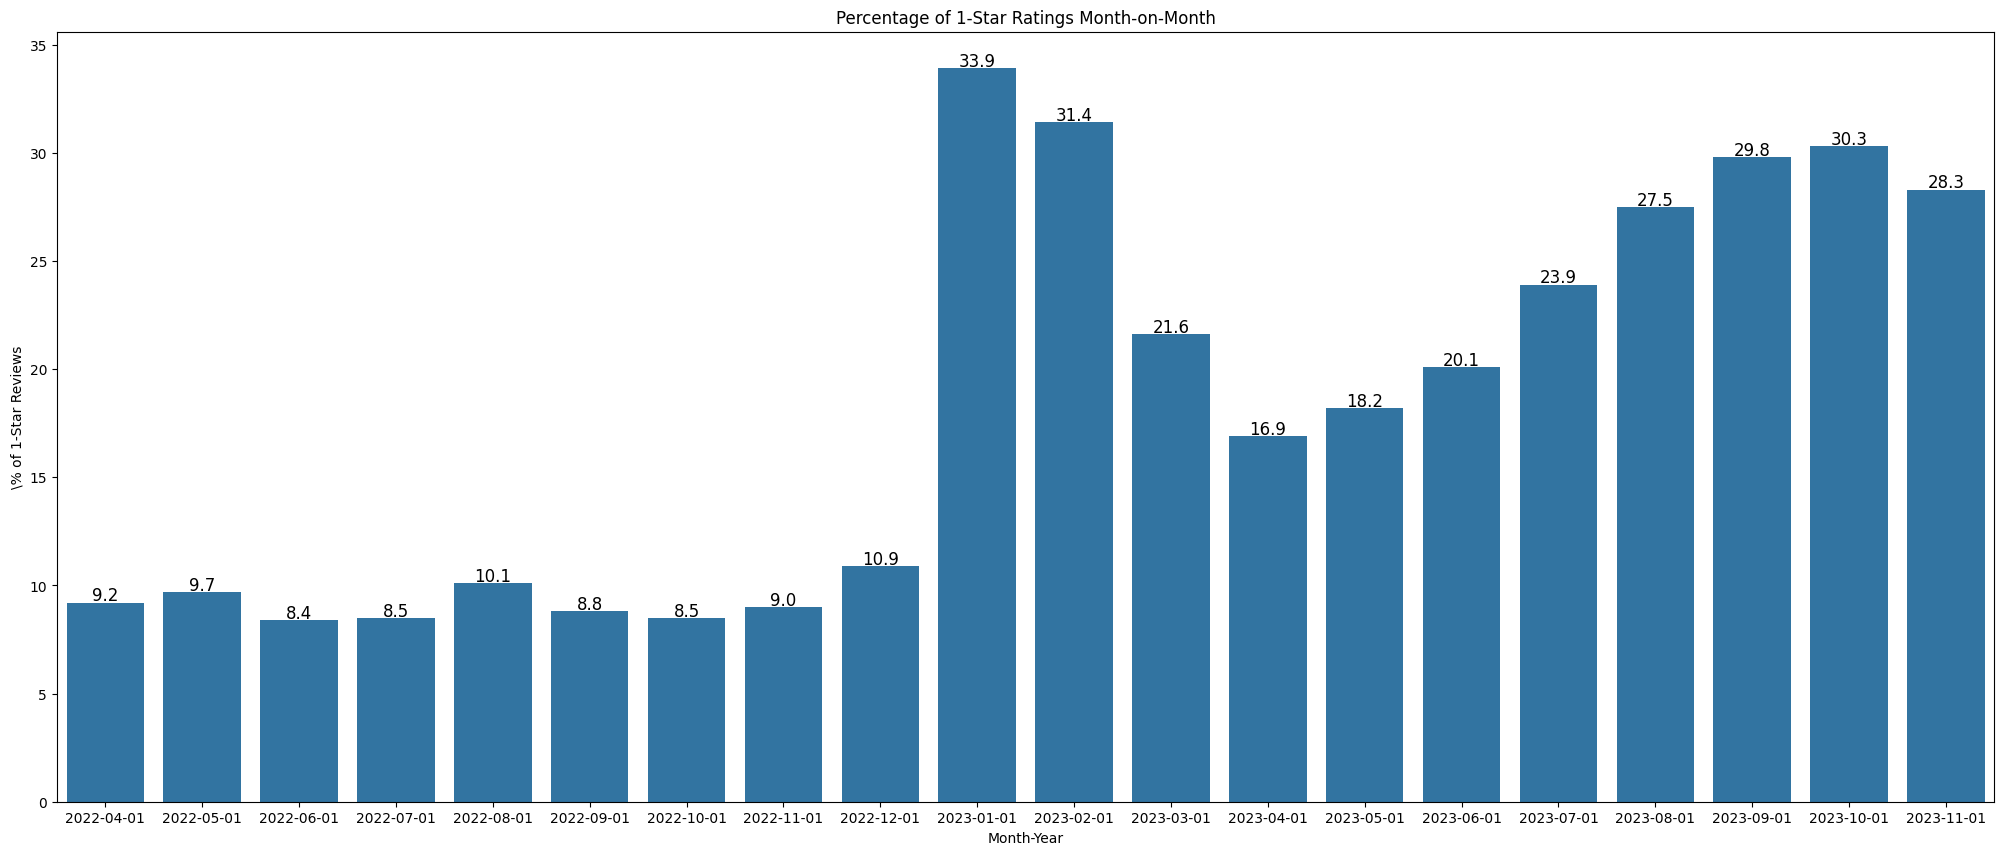

In [131]:
plot_barplots(df1=pivoted, x="Month-Year", y="1-Star %", 
              title="Percentage of 1-Star Ratings Month-on-Month", xlabel="Month-Year", 
              ylabel="\% of 1-Star Reviews")

## Company Reply Rate

Reply rate is the number of reviews replied by the company over the total review at a given period.

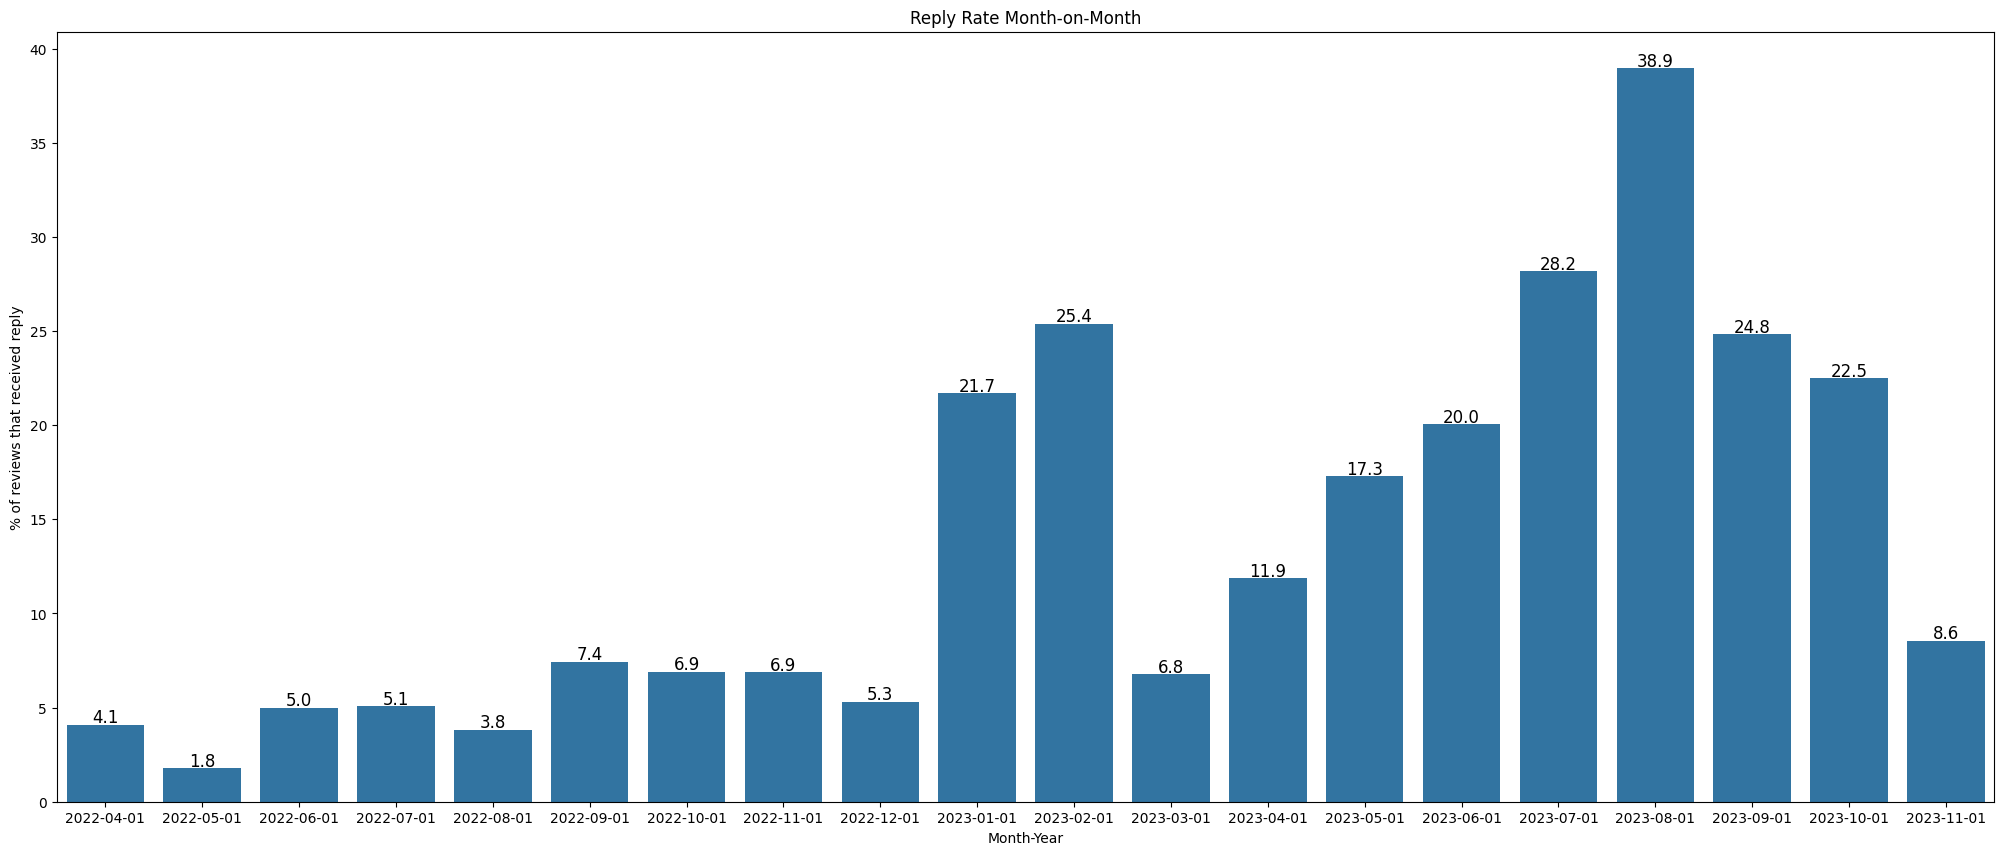

In [132]:
reply_rate = df.groupby('Month-Year')['CompanyReply'].apply(lambda x: (1-(x.isna().sum() / len(x))) * 100).reset_index(name='Reply Rate')

plot_barplots(df1=reply_rate, x="Month-Year", y="Reply Rate", 
              title="Reply Rate Month-on-Month", xlabel="Month-Year", 
              ylabel="% of reviews that received reply")

### Reply Rate for Negative Reviews

We are regarding 1-star and 2-star reviews as negative

In [133]:
df_low_ratings = df[df["stars"]<3]
reply_rate_for_low_ratings = df_low_ratings.groupby('Month-Year')['CompanyReply'].apply(lambda x: (1-(x.isna().sum() / len(x))) * 100).reset_index(name='Reply Rate')
print(reply_rate_for_low_ratings)

   Month-Year  Reply Rate
0  2022-04-01   28.096677
1  2022-05-01   12.087912
2  2022-06-01   38.988095
3  2022-07-01   41.643836
4  2022-08-01   20.403023
5  2022-09-01   56.666667
6  2022-10-01   53.097345
7  2022-11-01   53.773585
8  2022-12-01   35.675676
9  2023-01-01   51.953125
10 2023-02-01   69.767442
11 2023-03-01   19.642857
12 2023-04-01   35.652174
13 2023-05-01   59.763314
14 2023-06-01   51.343284
15 2023-07-01   74.402730
16 2023-08-01   93.312102
17 2023-09-01   48.442907
18 2023-10-01   37.967914
19 2023-11-01   13.636364


In [134]:
reply_rate_for_low_ratings["Reply Rate"].mean()

44.81585133869076

In [135]:
reply_rate_for_low_ratings['Year'] = reply_rate_for_low_ratings['Month-Year'].dt.year
reply_rate_for_low_ratings

reply_rate_for_low_ratings.groupby('Year').agg({'Reply Rate': 'mean'}).reset_index().round(1)

,Year,Reply Rate
0,2022,37.8
1,2023,50.5


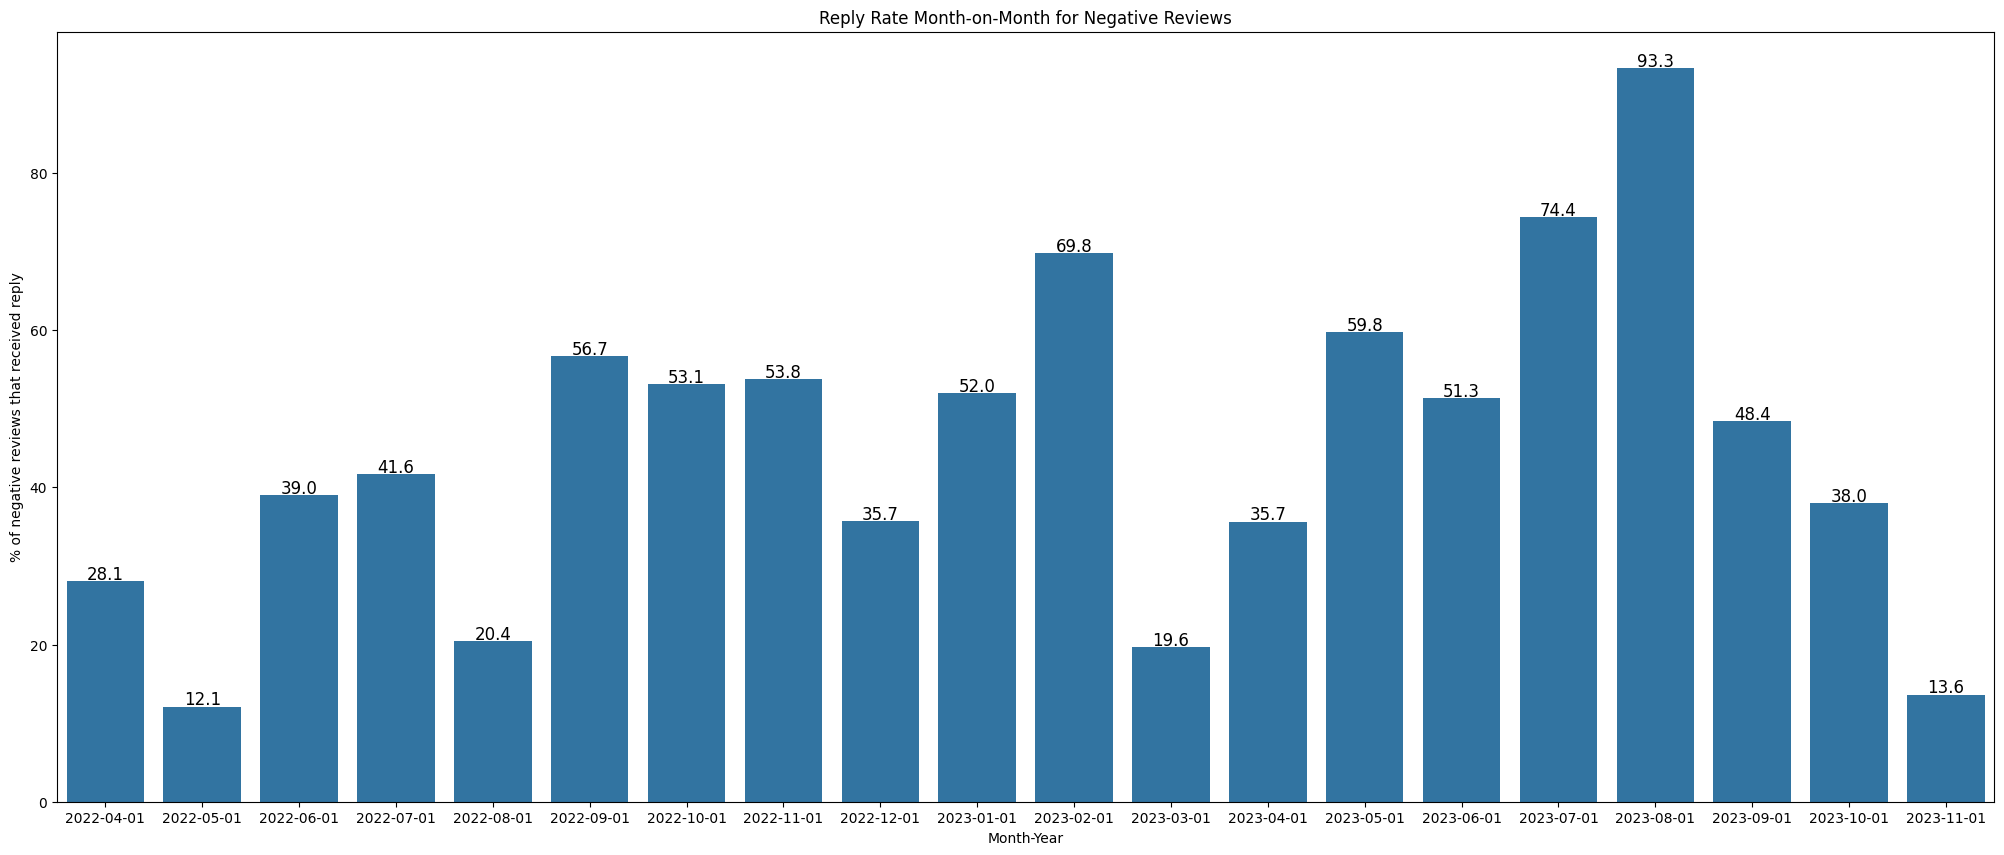

In [136]:
plot_barplots(df1=reply_rate_for_low_ratings, x="Month-Year", y="Reply Rate", 
              title="Reply Rate Month-on-Month for Negative Reviews", xlabel="Month-Year", 
              ylabel="% of negative reviews that received reply")

### Reply Rate for Positive Reviews

We are regarding 4-star and 5-star reviews as positive

In [137]:
df_high_ratings = df[df["stars"]>3]
reply_rate_for_high_ratings = df_high_ratings.groupby('Month-Year')['CompanyReply'].apply(lambda x: (1-(x.isna().sum() / len(x))) * 100).reset_index(name='Reply Rate')

print(reply_rate_for_high_ratings)

   Month-Year  Reply Rate
0  2022-04-01    0.037994
1  2022-05-01    0.110335
2  2022-06-01    0.069565
3  2022-07-01    0.000000
4  2022-08-01    0.036536
5  2022-09-01    0.000000
6  2022-10-01    0.138985
7  2022-11-01    0.228659
8  2022-12-01    0.160321
9  2023-01-01    0.000000
10 2023-02-01    0.600601
11 2023-03-01    0.124844
12 2023-04-01    4.939627
13 2023-05-01    4.106280
14 2023-06-01    8.971963
15 2023-07-01    8.891753
16 2023-08-01    8.412698
17 2023-09-01    9.765625
18 2023-10-01    9.818731
19 2023-11-01    2.654867


In [138]:
reply_rate_for_high_ratings['Year'] = reply_rate_for_high_ratings['Month-Year'].dt.year
reply_rate_for_high_ratings

reply_rate_for_high_ratings.groupby('Year').agg({'Reply Rate': 'mean'}).reset_index().round(1)

,Year,Reply Rate
0,2022,0.1
1,2023,5.3


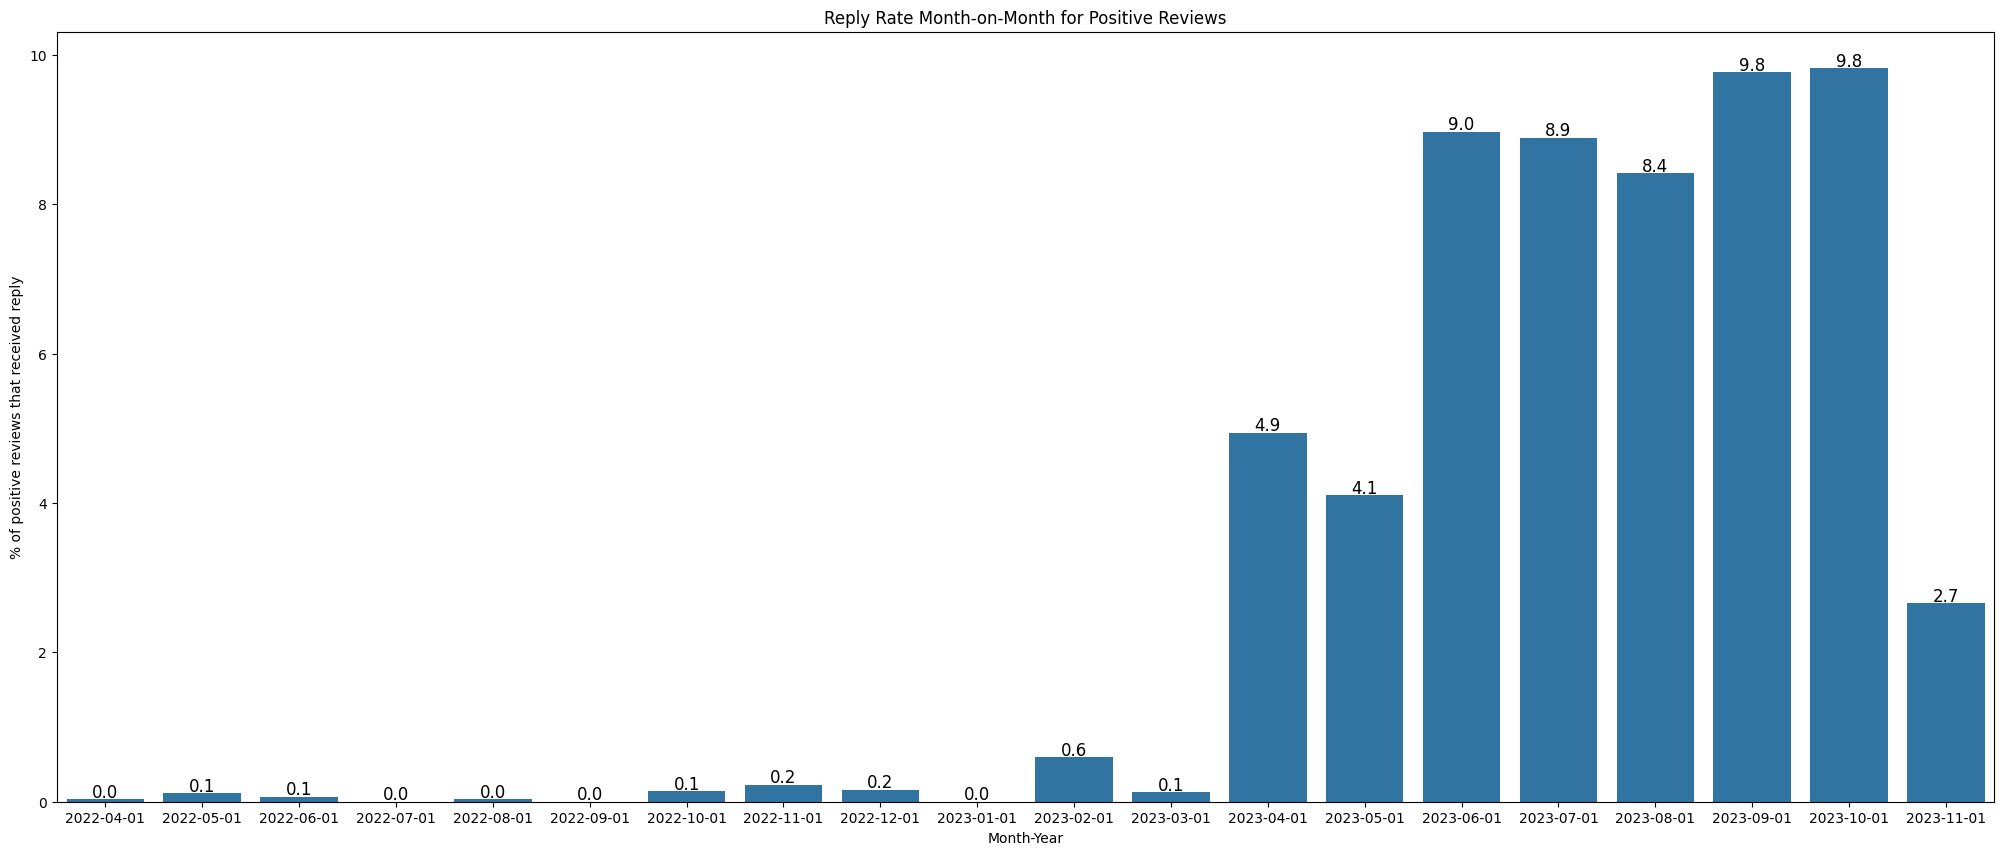

In [139]:
plot_barplots(df1=reply_rate_for_high_ratings, x="Month-Year", y="Reply Rate", 
              title="Reply Rate Month-on-Month for Positive Reviews", xlabel="Month-Year", 
              ylabel="% of positive reviews that received reply")

### Time Taken to Reply

In [140]:
# To filter reviews that received replies we need to check two things: 
# ensure that we have the reply on CompanyReply field, and 
# that time_taken_to_reply is non-negative. Remember that we set time_taken_to_reply to -999
# for messages that did not get replies
replied = df[(~df["CompanyReply"].isna()) & (df["time_taken_to_reply"]>=0)]

In [141]:
time_taken = replied.groupby('Month-Year').agg({'time_taken_to_reply': 'mean'}).reset_index()
time_taken['time_taken_to_reply'] = time_taken['time_taken_to_reply'].round(1)
print(time_taken)

   Month-Year  time_taken_to_reply
0  2022-04-01                 29.9
1  2022-05-01                  2.3
2  2022-06-01                  3.5
3  2022-07-01                 17.9
4  2022-08-01                  3.6
5  2022-09-01                  1.5
6  2022-10-01                  1.6
7  2022-11-01                  2.1
8  2022-12-01                  2.4
9  2023-01-01                  2.4
10 2023-02-01                  3.3
11 2023-03-01                  2.8
12 2023-04-01                 27.7
13 2023-05-01                 10.3
14 2023-06-01                  6.2
15 2023-07-01                  7.2
16 2023-08-01                  2.8
17 2023-09-01                  5.2
18 2023-10-01                  3.9
19 2023-11-01                  0.7


In [142]:
time_taken['Year'] = time_taken['Month-Year'].dt.year
time_taken

time_taken.groupby('Year').agg({'time_taken_to_reply': 'mean'}).reset_index().round(1)

,Year,time_taken_to_reply
0,2022,7.2
1,2023,6.6


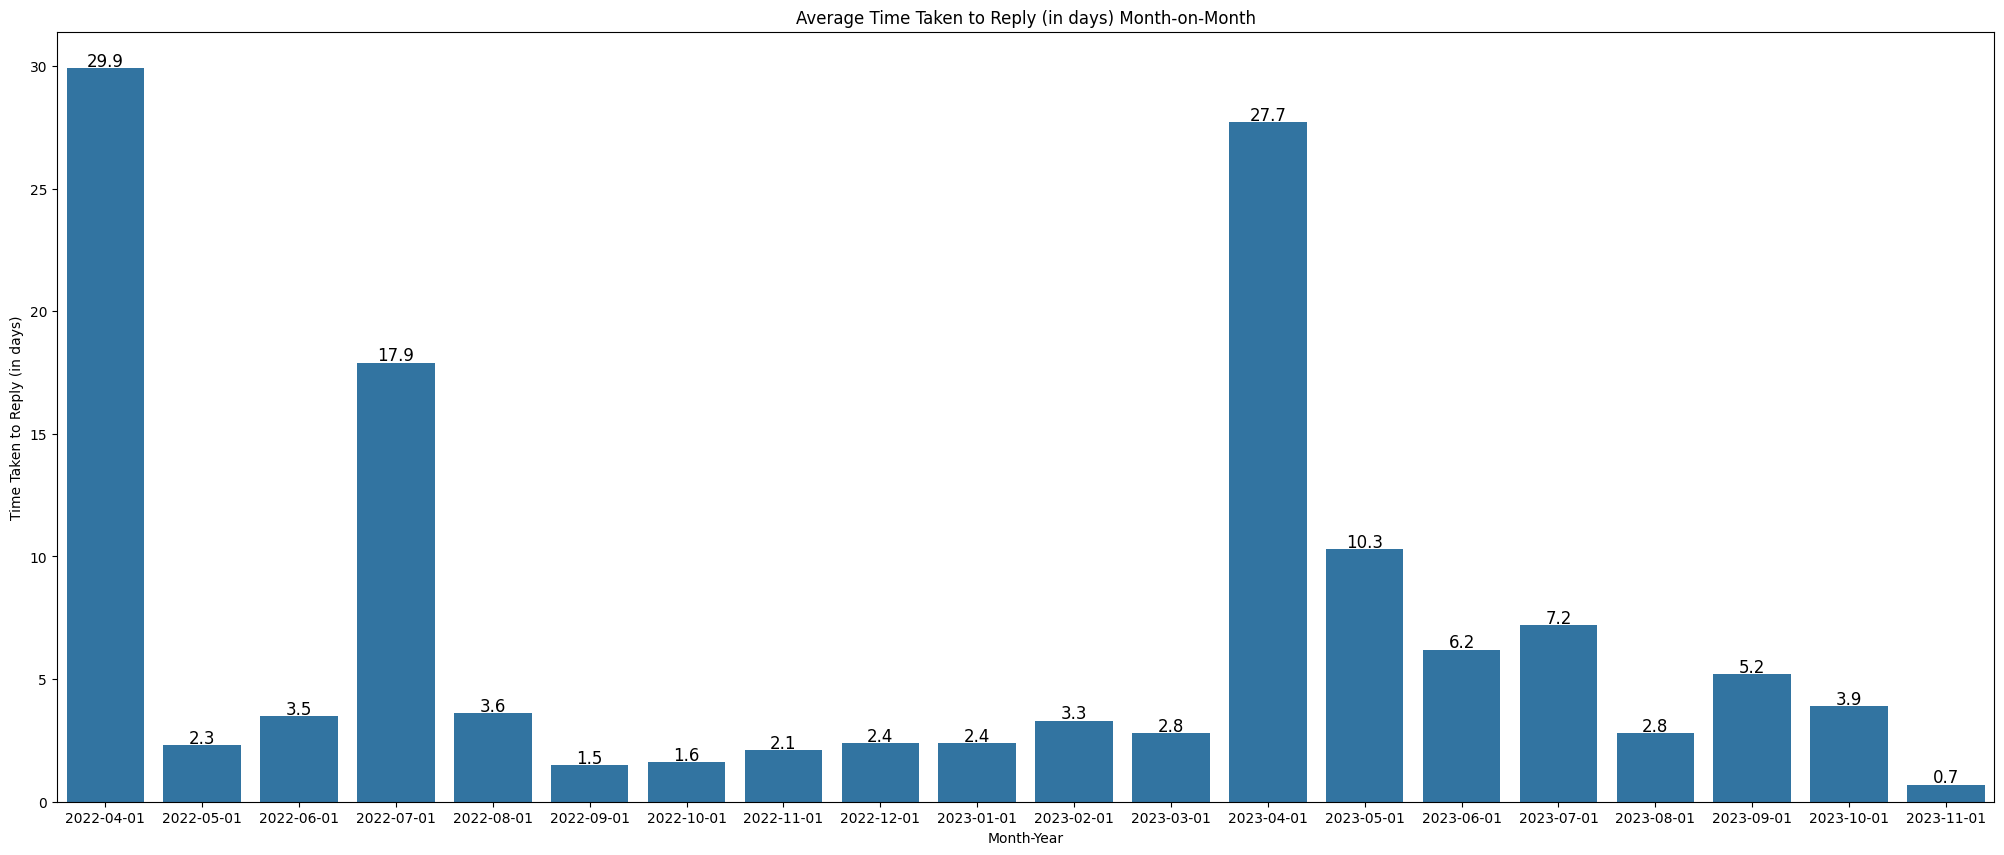

In [143]:
plot_barplots(df1=time_taken, x="Month-Year", y="time_taken_to_reply", 
              title="Average Time Taken to Reply (in days) Month-on-Month", xlabel="Month-Year", 
              ylabel="Time Taken to Reply (in days)")

#### Time taken to Reply to Negative Reviews

In [144]:
replied_low_ratings = replied[replied["stars"]<3].copy()

In [145]:
replied_low_ratings['Year'] = replied_low_ratings['Month-Year'].dt.year

replied_low_ratings.groupby('Year').agg({'time_taken_to_reply': 'mean'}).reset_index().round(1)

,Year,time_taken_to_reply
0,2022,6.3
1,2023,3.5


In [167]:
replies_over_time_low_ratings = replied_low_ratings.groupby('Month-Year').agg(
    Mean=('time_taken_to_reply', 'mean'),
    Count=('time_taken_to_reply', 'size')
).reset_index()

replies_over_time_low_ratings['Mean'] = replies_over_time_low_ratings['Mean'].round(1)
replies_over_time_low_ratings

,Month-Year,Mean,Count
0,2022-04-01,29.7,87
1,2022-05-01,2.0,34
2,2022-06-01,3.8,126
3,2022-07-01,17.4,147
4,2022-08-01,2.2,78
5,2022-09-01,1.6,181
6,2022-10-01,1.6,171
7,2022-11-01,2.2,162
8,2022-12-01,2.3,126
9,2023-01-01,2.5,124


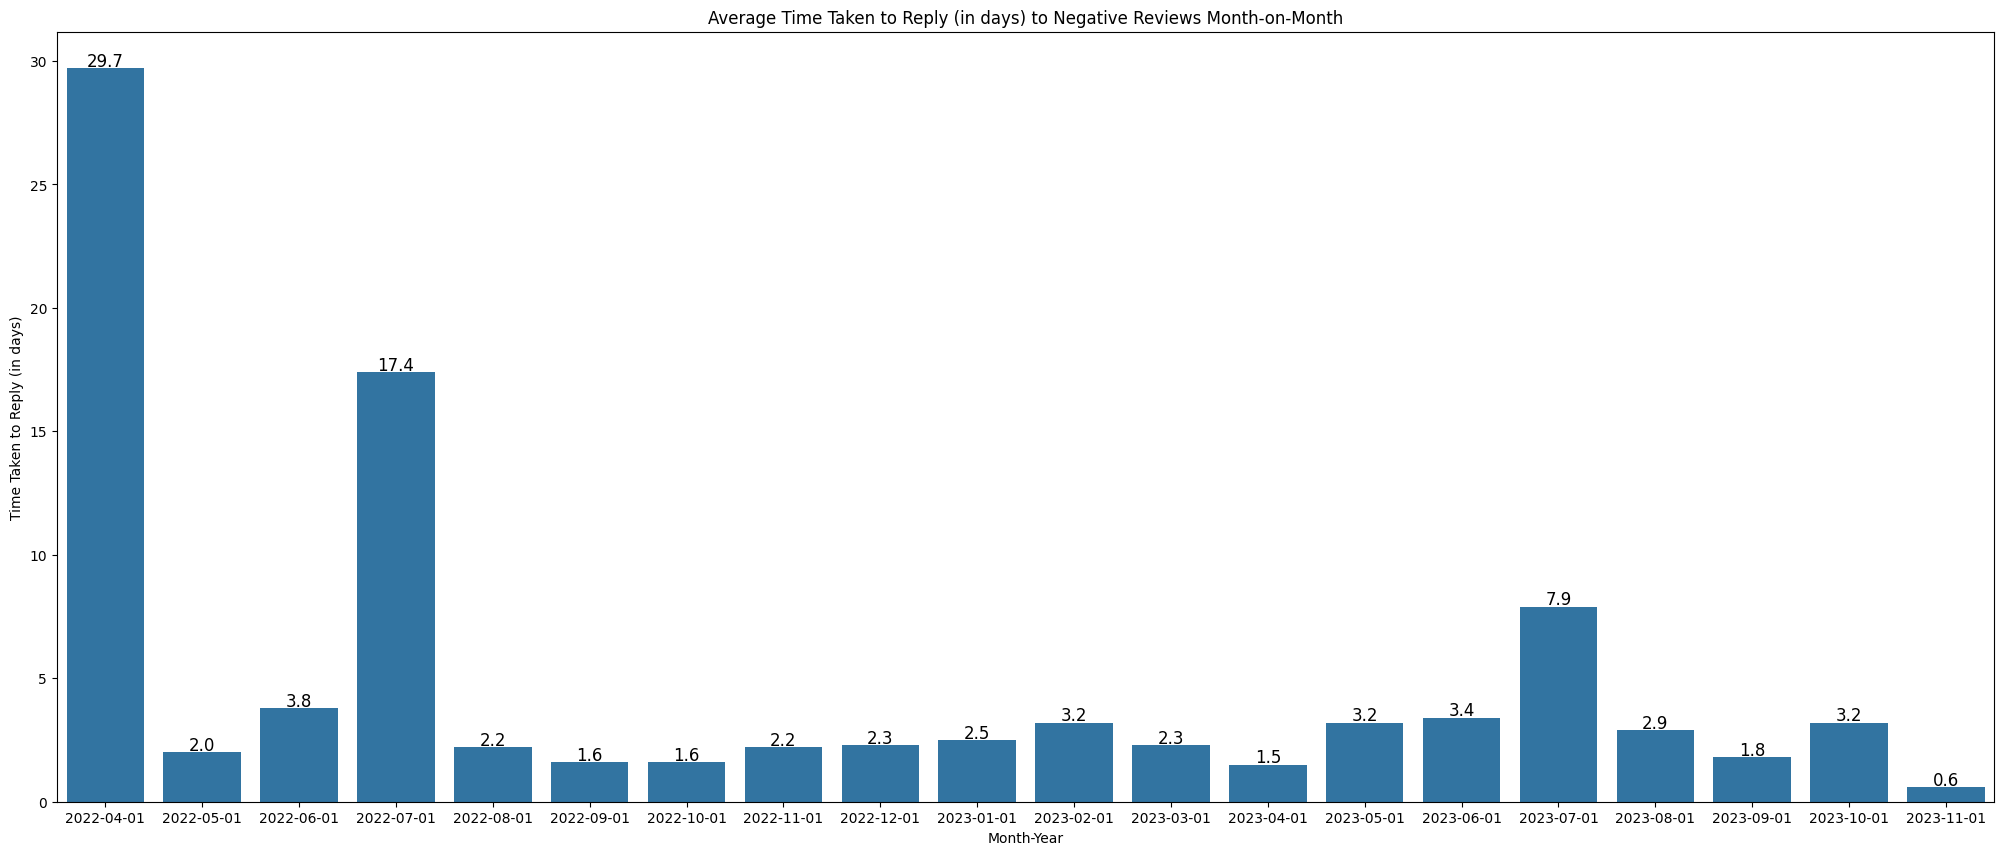

In [169]:
plot_barplots(df1=replies_over_time_low_ratings, x="Month-Year", y="Mean", 
              title="Average Time Taken to Reply (in days) to Negative Reviews Month-on-Month", 
              xlabel="Month-Year", 
              ylabel="Time Taken to Reply (in days)")

#### Time taken to Reply to Positive Reviews

In [161]:
replied_high_ratings = replied[replied["stars"]>3].copy()

In [174]:
replied_high_ratings['Year'] = replied_high_ratings['Month-Year'].dt.year
replied_high_ratings.groupby('Year').agg(Mean=('time_taken_to_reply', 'mean'),
    Count=('time_taken_to_reply', 'size')).reset_index().round(1)

,Year,Mean,Count
0,2022,0.0,6
1,2023,19.4,420


In [166]:
#replies_over_time_high_ratings = replied_high_ratings.groupby('Month-Year').agg({'time_taken_to_reply': 'mean'}).reset_index()

replies_over_time_high_ratings = replied_high_ratings.groupby('Month-Year').agg(
    Mean=('time_taken_to_reply', 'mean'),
    Count=('time_taken_to_reply', 'size')
).reset_index()


replies_over_time_high_ratings['Mean'] = replies_over_time_high_ratings['Mean'].round(2)

replies_over_time_high_ratings

,Month-Year,Mean,Count
0,2022-05-01,0.00,2
1,2022-10-01,0.00,2
2,2022-11-01,0.00,1
3,2022-12-01,0.00,1
4,2023-02-01,0.00,1
5,2023-03-01,0.00,1
6,2023-04-01,80.00,44
7,2023-05-01,42.42,50
8,2023-06-01,11.92,92
9,2023-07-01,4.94,67


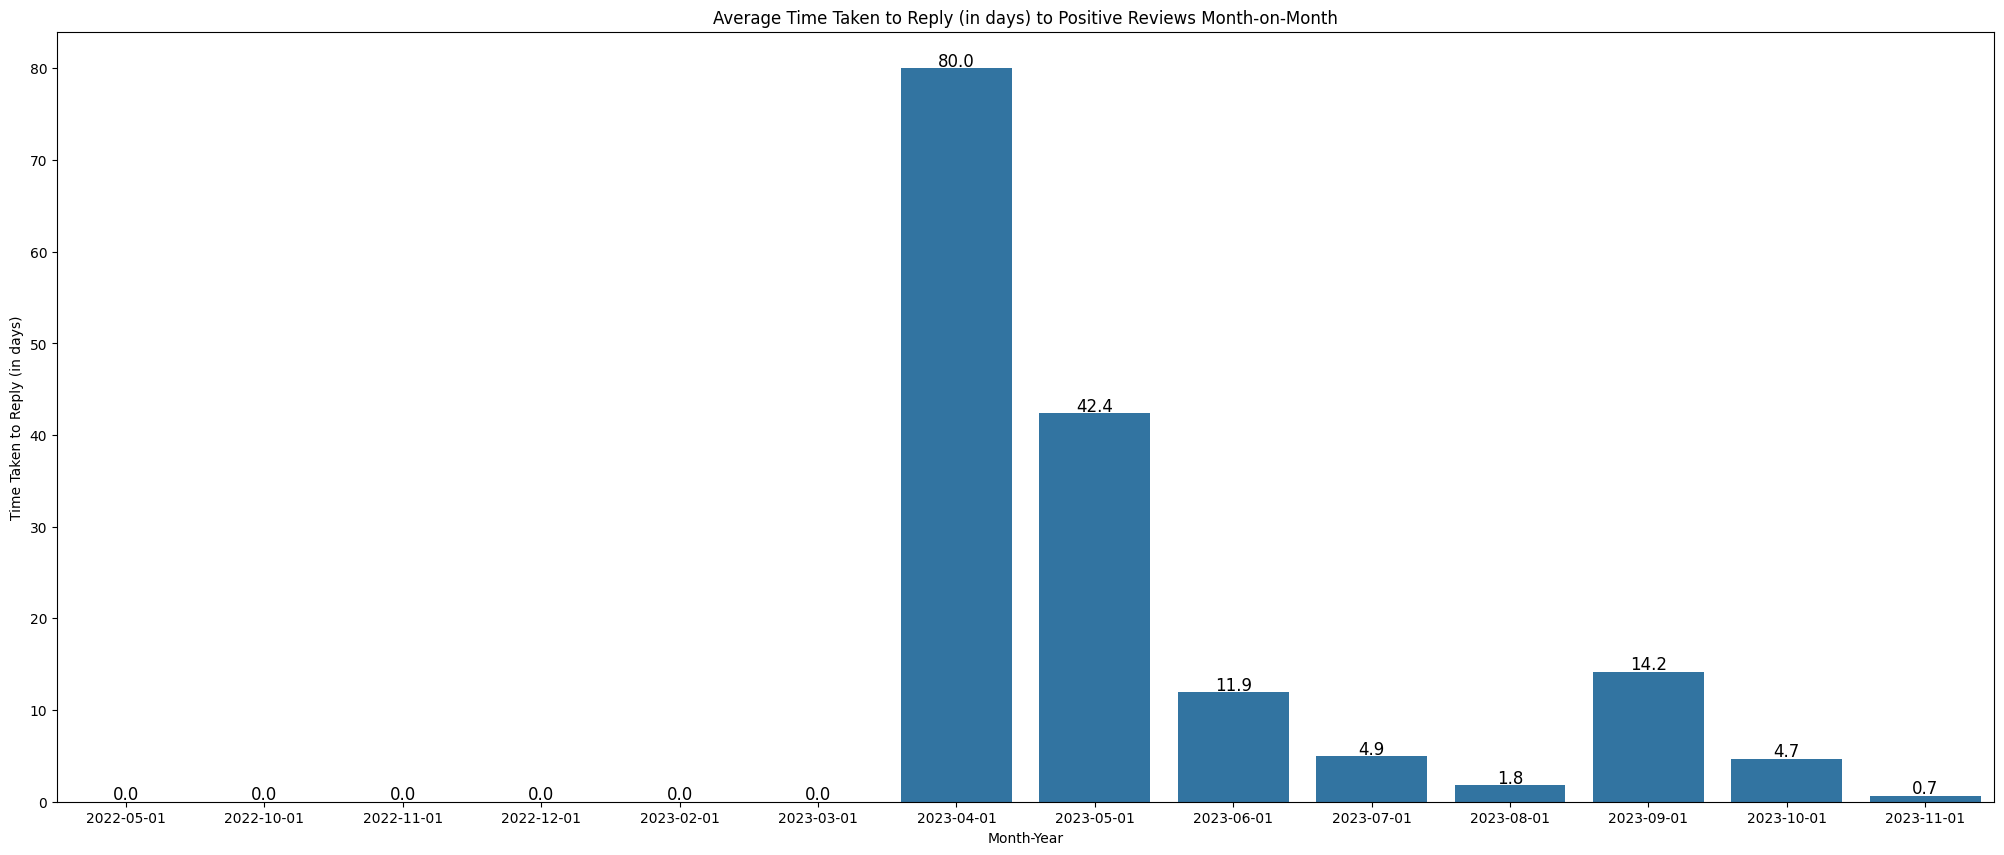

In [170]:
plot_barplots(df1=replies_over_time_high_ratings, x="Month-Year", y="Mean", 
              title="Average Time Taken to Reply (in days) to Positive Reviews Month-on-Month", 
              xlabel="Month-Year", 
              ylabel="Time Taken to Reply (in days)")